<center>
    <h2> <b> LINMA2450 : Combinatorial optimization </h2>
    <h1>   <b> Homework 2 - Exercise 2 </h1> 
</center>

Note that the first part is a solution to the sub-tour elimination formulation with the 42-cities problem. If you want to test with the 26-cities problem, please change "data42.txt" in "data26.txt" in the first cell of "Preliminaries" section and re-run the cells.

# Preliminaries

We load the data (see remark above) and we build cost vector and indices matrix to match indices of nodes with index of edges : ind[i,j] = e(i,j) = e(j,i) with e(i,j) the edge from i to j or inversely.

In [538]:
# load data
using DelimitedFiles, LinearAlgebra
dist = readdlm("data42.txt",Int)     # modify in "data26.txt" in order to test 26-cities TSP

V = size(dist)[1]
E = (V-1)*(V) ÷ 2

function index(i,j)
    return (i-2)*(i-1) ÷ 2 + j # Lazy Caterer's sequence + (j-1)
end

ind = zeros(Int, (V,V)) # construct matrix with 2 Floyd's triangle
c = zeros(Int, E) # construct cost vector

for i = 2:V
    for j = 1:i-1
        ind_ij = index(i,j)
        ind[i,j] = ind_ij
        c[ind_ij] = dist[i,j] 
    end
end
ind = ind + transpose(ind)
_=0

0

The following function min_cut solves \
\
$ \min_{w \in \mathbb{R}^{|E|}, u \in \mathbb{R}^{|V| \times |V|}} \sum_{e \in E} h_ew_e $ \
\
such that \
$ u_i - u_j + w_{e(i,j)} \geq 0 $ for all $i,j \in V$ with $e(i,j)$ the edge from $i$ to $j$ or inversely \
$ u_t - u_s  \geq 1 $ \
$ w_e \geq 0 $ for all $e\in E$.

In [539]:
function min_cut(s,t,h,ind)
    model = Model(with_optimizer(Gurobi.Optimizer))
    set_optimizer_attribute(model, "Presolve", 0)
    set_optimizer_attribute(model, "Heuristics", 0)
    set_optimizer_attribute(model, "Cuts", 0)
    set_silent(model)
    
    E = size(h)[1]
    V = size(ind)[1]
    
    # variables
    @variable(model,0 <= w[1:E])
    @variable(model,u[1:V])
    
    # objective function
    @objective(model, Min, sum(h .* w))
    
    # constraints
    for e = 1:E
        ij = findall(x->(x==e),ind)[1]
        i = ij[1]
        j = ij[2]
        @constraint(model,w[e]>=u[i]-u[j])
        @constraint(model,w[e]>=u[j]-u[i])
    end
    @constraint(model,u[t]-u[s]>=1)
    
    optimize!(model)
    return sum(h.*value.(w)), findall(x->x==0.0,value.(u))
end

min_cut (generic function with 2 methods)

The following function returns the indices of every edge that link a node in S and a node in V \ S.

In [540]:
function delta(S,ind)
    
    V = size(ind)[1]
    E = V*(V-1) ÷ 2 
    
    indices_total = Set{Int}()
    for e = 1:E
        ij = findall(x->(x==e),ind)[1]
        i = ij[1]
        j = ij[2]
                
        if ((i in S) && !(j in S)) || (!(i in S) && (j in S))
            push!(indices_total,e)
        end
    end
    
    return collect(indices_total)
end

delta (generic function with 1 method)

# Initialization of the LP optimization model

We initialize the model without any constraint of type (3) (from the statement).

In [541]:
using Gurobi, JuMP

model = Model(with_optimizer(Gurobi.Optimizer))
set_optimizer_attribute(model, "Presolve", 0)
set_optimizer_attribute(model, "Heuristics", 0)
set_optimizer_attribute(model, "Cuts", 0)
set_silent(model)

# define variables and constraints for the initial LP problem
@variable(model,0 <= x[1:E] <= 1)
@objective(model,Min,sum(c.*x))
for i = 1:V 
    indices = filter!(x -> x ≠ 0,ind[:,i])
    @constraint(model,sum(x[indices]) == 2)
end


--------------------------------------------
--------------------------------------------

Academic license - for non-commercial use only


# Cut phase : add constraints

We add constraints of type (3) as explained in the solution of Question 1 in the report.

In [542]:
# initialization
optimize!(model)
opt_x = value.(x)

print(objective_value(model))

# loop
count=0
count2=0
#while true
#    t=2
#    while t ≠ V+1
#        cut_val,S = min_cut(1,t,opt_x,ind)
#        count2 = count2+1
#        if cut_val < 2
#            count = count+1
#            ind_cons = delta(S,ind)
#            @constraint(model,sum(x[ind_cons]) >= 2)
#            optimize!(model)
#            opt_x = value.(x)
#            break
#        end
#        t = t+1
#    end
#    if t==V+1
#        break
#    end
#end

while true
    min_cut_val, min_S = min_cut(1,2,opt_x,ind)     # initialization
    count2 = count2+1
    for t = 3:V
        cut_val,S = min_cut(1,t,opt_x,ind)
        if cut_val<min_cut_val
            min_cut_val = cut_val
            min_S = S
        end
        count2 = count2+1
    end
    if min_cut_val < 2                              # min_S s.t. \bar{x} violates (3)
        count = count+1
        ind_cons = delta(min_S,ind)
        @constraint(model,sum(x[ind_cons]) >= 2)
        optimize!(model)
        opt_x = value.(x)
    else                                            # no more S s.t. \bar{x} violates (3)
        break
    end
end

print("\nNumber of min cuts solved : ")
print(count2)
print("\nNumber of constraints added : ")
print(count)


--------------------------------------------
--------------------------------------------

Academic license - for non-commercial use only
641.0
--------------------------------------------
--------------------------------------------

Academic license - for non-commercial use only

--------------------------------------------
--------------------------------------------

Academic license - for non-commercial use only

--------------------------------------------
--------------------------------------------

Academic license - for non-commercial use only

--------------------------------------------
--------------------------------------------

Academic license - for non-commercial use only

--------------------------------------------
--------------------------------------------

Academic license - for non-commercial use only

--------------------------------------------
--------------------------------------------

Academic license - for non-commercial use only

---------------------


Number of min cuts solved : 328
Number of constraints added : 7

# Branch phase : IP solution

We have the rood node for the branch and bound. We look at the relaxed solution (LP problem) and then we constraint variables to be binary and we apply the branch&bound algorithm to look at the integer solution (IP problem). 

In [543]:
# Now we solve the LP problem

print("LP solution : ")
optimize!(model)
print(objective_value(model))
print("\nSome non-binary variables ? : ")

LP_opt_x = value.(x)
# check
print(LP_opt_x[findall(x->(x ≠ 1.0)&&(x ≠ 0.0),LP_opt_x)]) # we have some non-binary variables
print("\n\n")

# we constraint variables to be binary
for e = 1:E
    @constraint(model, x[e] in JuMP.MOI.ZeroOne())
end

print("Now we apply branch&bound : \n\n")

unset_silent(model)

# Now we solve the IP problem

optimize!(model)

print("\nIP solution : ")
print(objective_value(model))

print("\nSome non-binary variables ? : ")
IP_opt_x = value.(x)
# check
print(IP_opt_x[findall(x->(x ≠ 1.0)&&(x ≠ 0.0),IP_opt_x)])
print("\n")

LP solution : 697.0
Some non-binary variables ? : [0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5]

Now we apply branch&bound : 

Gurobi Optimizer version 9.0.3 build v9.0.3rc0 (mac64)
Optimize a model with 49 rows, 861 columns and 3566 nonzeros
Model fingerprint: 0x7ec51797
Variable types: 0 continuous, 861 integer (861 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [3e+00, 2e+02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [2e+00, 2e+00]
Variable types: 0 continuous, 861 integer (861 binary)

Root relaxation: objective 6.970000e+02, 85 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0  697.00000    0   16          -  697.00000      -     -    0s
     0     0  697.00000    0   16          -  697.00000      -     -    0s
     0     2  697.00000    0   16          -  697.

# Plot

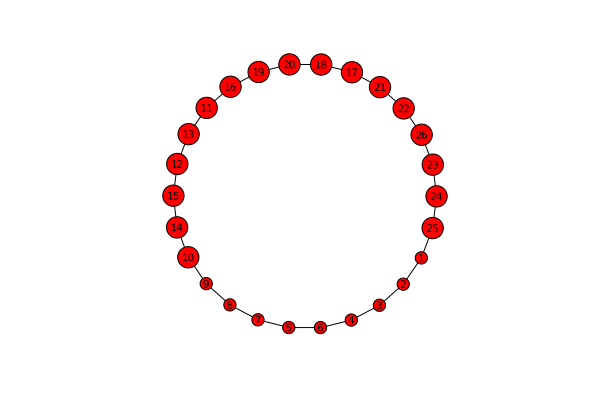

In [471]:
using GraphRecipes
using Plots

A = zeros(Int,(V,V))
for e = 1:E
    ij = findall(x->x==e,ind)[1]
    i=ij[1]
    j=ij[2]

    A[i,j] = IP_opt_x[e]
    A[j,i] = IP_opt_x[e]
end

graphplot(A,
          markersize = 0.2,
          node_weights = ones(V),
          names = 1:V,
          markercolor = colorant"red",
          curves=false,
          nodeshape=:circle)

<center>
    <h1>   <b> Homework 2 - Exercise 3 </h1> 
</center>

# Preliminaries

We load the data.

In [546]:
# load data
using DelimitedFiles, LinearAlgebra
dist = readdlm("data26.txt",Int)

V = size(dist)[1]
E = (V-1)*(V) ÷ 2

861

# Model

We define the Miller-Tucker-Zemlin(MTZ) formulation and we optimize it with branch&bound.

In [ ]:
model = Model(with_optimizer(Gurobi.Optimizer))
set_optimizer_attribute(model, "Presolve", 0)
set_optimizer_attribute(model, "Heuristics", 0)
set_optimizer_attribute(model, "Cuts", 0)

@variable(model, x[1:V,1:V], Bin)
@variable(model, 1 <= u[2:V] <= V-1)
@objective(model, Min, sum(dist.*x))

@constraint(model,diag(x).==0)                         # diag -> 0
@constraint(model,sum(x,dims=1).==1)                   # (6)
@constraint(model,sum(x,dims=2).==1)                   # (7)
@constraint(model,[i = 2:V,j = 2:V],u[i]-u[j]+(V-1)*x[i,j]<=V-2)

optimize!(model)
#print(value.(u))
objective_value(model)

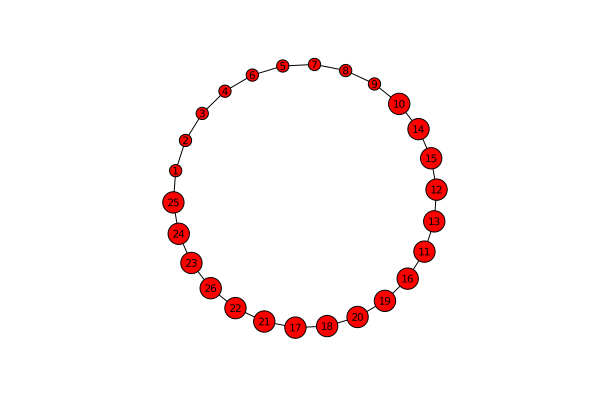

In [474]:
graphplot(value.(x),
          markersize = 0.2,
          node_weights = ones(V),
          names = 1:V,
          markercolor = colorant"red",
          curves=false,
          nodeshape=:circle)